# Prepare SST dataset for comparison with CESM-LE

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import os
from glob import glob
import subprocess
import urllib
import calendar
from datetime import datetime
import tqdm

import numpy as np

import dask
import xarray as xr

import pop_tools

import util

In [82]:
clobber = False
dst_grid = 'POP_gx1v6'

FILE_OUT_DJF = f'{util.project_tmpdir}/HadISST_DJF.{dst_grid}.zarr'
FILE_OUT_ANN = f'{util.project_tmpdir}/HadISST_ANN.{dst_grid}.zarr'
FILE_OUT_DJF

'/glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_DJF.POP_gx1v6.zarr'

## Setup regridding machinery

Make SCRIP grid file for source grid.

In [83]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [84]:
src_grid = 'latlon_1x1_lon180'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=360, 
        ny=180, 
        lon0=-180., 
        file_out=src_grid_file,
    )

Make SCRIP grid file for ocean model grid.

In [85]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

Call `ESMF_RegridWeightGen` to generate weight file.

In [86]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

CPU times: user 107 µs, sys: 0 ns, total: 107 µs
Wall time: 66.5 µs


Set up remapping operator

In [87]:
regrid_op = util.regridder(src_grid_file, dst_grid_file, weight_file)
regrid_op

source grid dims: (180, 360)
destination grid dims: (384, 320)


regridder latlon_1x1_lon180.nc --> POP_gx1v6.nc

## Download and process files

Set up some directories and xarray option for reading files.

In [88]:
dirloc = f'{util.project_tmpdir}/HadISST'
dirtmp = f'/glade/work/{os.environ["USER"]}/HadISST'
os.makedirs(dirloc, exist_ok=True)
os.makedirs(dirtmp, exist_ok=True)

Define a function for computing monthly means from daily files.

In [89]:
os.getcwd()

'/glade/u/home/mclong/p/krill-cesm-le/notebooks'

In [90]:
f_local = f'{dirtmp}/HadISST_sst.nc'
if not os.path.exists(f_local):
    cwd = os.getcwd()
    os.chdir(dirtmp)
    url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz'
    subprocess.run(['wget', url])
    subprocess.run(['gunzip', 'HadISST_sst.nc.gz'])
    os.chdir(cwd)

ds_in = xr.open_dataset(f_local, decode_times=False, decode_coords=False)
ds_in.time.attrs['bounds'] = 'time_bnds'
with xr.set_options(keep_attrs=True):
    ds_in['sst'] = ds_in.sst.where(ds_in.sst != -1000.)
ds_in

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1804)
Coordinates:
  * time       (time) float32 15.499994 44.999992 74.49999 ... 54861.5 54892.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    10/6/2020 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [101]:
%%time
f_local_dst = f_local.replace('.nc', f'_{dst_grid}.nc')
if not os.path.exists(f_local_dst):
    ds = xr.Dataset({'time': ds_in.time, 'time_bnds': ds_in.time_bnds})
    ds['sst'] = regrid_op.regrid_dataarray(
                ds_in.sst[:, ::-1, :], # latitude is upside down 
                renormalize=True, 
                apply_mask=True,
    )

    ds.attrs = ds_in.attrs

    ds = ds.rename(latitude='nlat', longitude='nlon')

    time_bnds = ds[ds.time.bounds]
    ds = xr.decode_cf(ds.drop(ds.time.bounds), decode_times=True, use_cftime=True)
    ds['time_bnds'] = time_bnds.assign_coords(time=ds.time)

    pop_grid = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
    ds = xr.merge((ds, pop_grid))
    
    print(f'writing {f_local_dst}')
    ds.to_netcdf(f_local_dst)
ds

writing /glade/work/mclong/HadISST/HadISST_sst_POP_gx1v6.nc
CPU times: user 4.41 s, sys: 6.72 s, total: 11.1 s
Wall time: 11.3 s


<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, nv: 2, time: 1804)
Coordinates:
  * time       (time) object 1870-01-16 11:59:59.505615 ... 2020-04-16 12:00:00
Dimensions without coordinates: nlat, nlon, nv
Data variables:
    sst        (time, nlat, nlon) float64 ...
    time_bnds  (time, nv) float32 0.0 30.999989 31.0 ... 54877.0 54877.0 54908.0
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    KMT        (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12

In [92]:
%%time
ds_djf = util.ann_mean(ds, season='DJF')
ds_ann = util.ann_mean(ds)


CPU times: user 24.6 s, sys: 15.4 s, total: 39.9 s
Wall time: 40.2 s


In [93]:
util.write_ds_out(ds_djf, FILE_OUT_DJF)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 150 ;

variables:
	float64 sst(time, nlat, nlon) ;
		sst:standard_name = sea_surface_temperature ;
		sst:long_name = sst ;
		sst:units = C ;
		sst:cell_methods = time: lat: lon: mean ;
	float64 TLAT(time, nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(time, nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 KMT(time, nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TAREA(time, nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int64 time(time) ;

// global attributes:
}


In [94]:
util.write_ds_out(ds_ann, FILE_OUT_ANN)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_ANN.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 150 ;

variables:
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 sst(time, nlat, nlon) ;
		sst:standard_name = sea_surface_temperature ;
		sst:long_name = sst ;
		sst:units = C ;
		sst:cell_methods = time: lat: lon: mean ;
	int64 time(time) ;

// global attributes:
}


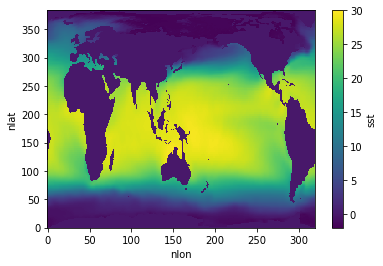

In [95]:
ds_djf.sst.mean('time').plot(vmin=-2, vmax=30)

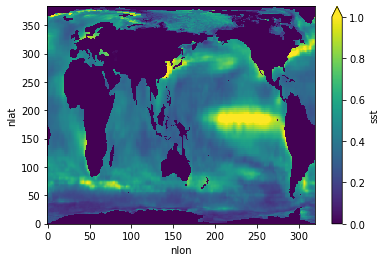

In [96]:
ds_djf.sst.std('time').plot(vmin=0, vmax=1)

In [97]:
ds_djf.sst.isel(time=-1).min().values

array(-1.80000001)

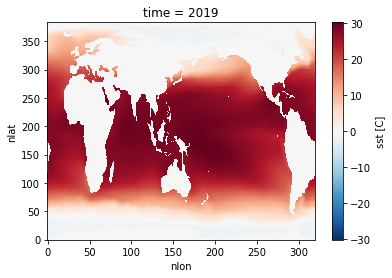

In [99]:
ds_ann.sst.isel(time=-1).plot()